<img src="https://i.postimg.cc/ydZcb9cY/Hello.jpg">

https://www.kaggle.com/datasets/thomasdubail/brain-tumors-256x256

<img src="https://i.postimg.cc/QdHhq8qX/Brain-Tumor-2-25-2024.png">

<img src="https://i.postimg.cc/nzqPFBVd/Brain-MRI.jpg">

<div style="background-color:#e1dee3; padding: 20px; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1);border:2px solid #0A2342">
    <h1 style="font-size:24px; font-family:calibri; color:#0A2342;"><b>Notebook Structure</b></h1>
    <p style="font-size:20px; font-family:calibri; line-height: 1.5em; text-indent: 20px;">In this project, mainly I use keras and cv2 to main structure and matplotlib and seaborn to visualization. This is Deep Learning project that use Convolutional Neural Network to work on images and make a accurate model.</p>
    <p style="font-size:20px; font-family:calibri; line-height: 1.5em; text-indent: 20px;"> We start with reading and loadin dataset. Then apply some preprocessing on dataset and images and then create a model to train. when we reach acceptable evaluation of model, make a prediction part with ipywidget (Button ux).
</div>

<div style="background-color:#e1dee3; padding: 20px; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1);border:2px solid #0A2342">
    <h1 style="font-size:24px; font-family:calibri; color:#0A2342;"><b>Context</b></h1>
    <p style="font-size:20px; font-family:calibri; line-height: 1.5em; text-indent: 20px;">In this project, we have a image dataset of about 3096 Brain MRI image that classified in 4 classes ('normal', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor').
    Our target is to make a classification model to detect kind of brain tumor in MRIs.
    </p>
</div>

# <div style="background-color:#0A2342;background-size: cover;font-family:tahoma;font-size:175%;text-align:center;border-radius:25px 50px; padding:10px; border:solid 2px #09375b"><span style="color:#f2f2f2"><b>Table Of Content</b></span></div>

<a id='tbl_content'></a>
<div style="background-color:#eef1fb; padding: 20px 10px 10px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1)">
    <ul>
        <li><a href="#step1" style="font-size:24px; font-family:calibri; font-weight:bold"> Step 1 | Initila Configurations </a></li>
            <ul>
                <li><a href="#step11" style="font-size:18px; font-family:calibri"> Step 1.1 | Import Python Libraries </a></li>
                <li><a href="#step12" style="font-size:18px; font-family:calibri"> Step 1.2 | Colors </a></li>
            </ul>
        <li><a href="#step1" style="font-size:24px; font-family:calibri; font-weight:bold"> Step 2 | Load Data </a></li>
            <ul>
                <li><a href="#step21" style="font-size:18px; font-family:calibri" > Step 2.1 | Load and Read Data </a></li>
                <li><a href="#step22"> Step 2.2 | Plot and Count Images </a></li>
            </ul>
        <li><a href="#step3" style="font-size:24px; font-family:calibri; font-weight:bold"> Step 3 | Data Preprocessing </a></li>
            <ul>
                <li><a href="#step31" style="font-size:18px; font-family:calibri"> Step 3.1 | Create Tesorflow Dataset </li>
                <li><a href="#step31" style="font-size:18px; font-family:calibri"> Step 3.2 | Create Train, Validation and Test Dataset </li>
            </ul>
        <li><a href="#step4" style="font-size:24px; font-family:calibri; font-weight:bold"> Step 4 | Modeling </a></li>
            <ul>
                <li><a href="#step41" style="font-size:18px; font-family:calibri"> Step 4.1 | Pre-Trained Model </a></li>
                <li><a href="#step42" style="font-size:18px; font-family:calibri"> Step 4.2 | Freeze Pre-Trained Model Layers </a></li>
                <li><a href="#step43" style="font-size:18px; font-family:calibri"> Step 4.3 | Define Layers For Join Pre-Trained Model </a></li>
                <li><a href="#step44" style="font-size:18px; font-family:calibri"> Step 4.4 | Compile Model </a></li>
                <li><a href="#step45" style="font-size:18px; font-family:calibri"> Step 4.5 | Call-Backs </a></li>
                <li><a href="#step46" style="font-size:18px; font-family:calibri"> Step 4.6 | Train Model </a></li>
                <li><a href="#step47" style="font-size:18px; font-family:calibri"> Step 4.7 | Evaluation </a></li>
            </ul>
        <li><a href="#step5" style="font-size:24px; font-family:calibri; font-weight:bold"> Step 5 | Predict </a></li>
        <li><a href="#author" style="font-size:24px; font-family:calibri; font-weight:bold"> Step 6 | Author </a></li>
    </ul>

</div>

<div style="background-color:#c5d8d1; padding: 0px 0px 0px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:70px; font-family:tahoma; line-height: 2em; text-indent: 10px; font-weight:bolder; color:#0A2342">Lets Go !
    </p>
</div>

# <a id='step1'></a>
# <div style="background-color:#0A2342;background-size: cover;font-family:tahoma;font-size:175%;text-align:center;border-radius:25px 50px; padding:10px; border:solid 2px #09375b"><span style="color:red"><b>Step 1 | <b></span><span style="color:#f2f2f2"><b>Initila Configurations</b></span></div>

##### [🏠 Tabel of Contents](#tbl_content)

<a id='step11'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 1.1 | <b></span><span style="color:#1d84b5"><b>Import Python Libraries</b></span></span>

<div style="background-color:#f4edea; padding: 20px 10px 10px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ At first, to avoid tensorflow and python warnings, use <b>silence_tensorflow</b> and <b>warnings</b> library. Because silence_tensorflow not installed in kaggle by default, try to install it with <b>pip</b> comand.
    </p>
    <p style="font-size:18px; font-family:tahoma; line-height: 1.5em; text-indent: 20px;">➡️ Then import necessary python-libraries that install before with <code>pip install command</code> comand.
    </p>
</div>

In [ ]:
# ! pip install silence_tensorflow

In [1]:
# To avoid tensorflow warnings
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

# To avoid other python wsrnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt

import keras
import keras_cv
import tensorflow as tf

import io
from PIL import Image
from ipywidgets import FileUpload
from IPython.display import display,clear_output

print(colored('All libraries imported succesfully', 'green', attrs=['bold']))

2024-02-25 23:39:34.804117: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 23:39:34.804427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 23:39:35.207482: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-25 23:39:36.209089: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-25 23:39:41.787950: W tensorflow/compiler/tf2

All libraries imported succesfully


<a id='step12'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 1.2 | <b></span><span style="color:#1d84b5"><b>Colors</b></span></span>

<div style="background-color:#f4edea; padding: 20px 10px 10px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ Here, Create a pallete of color that i used in this notebook with seaborn librariy.
    </p>
</div>

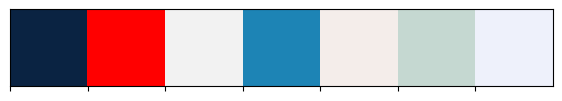

In [3]:
colors_dark = ["#0A2342", '#ff0000', '#f2f2f2', "#1d84b5" , '#f4edea', '#c5d8d1', '#eef1fb']

sns.palplot(colors_dark)

In [10]:
# Set seaborn plot style to darkgrid
sns.set_style('darkgrid')

<a id='step2'></a>
# <div style="background-color:#0A2342;background-size: cover;font-family:tahoma;font-size:175%;text-align:center;border-radius:25px 50px; padding:10px; border:solid 2px #09375b"><span style="color:red"><b>Step 2 | <b></span><span style="color:#f2f2f2"><b>Load Data</b></span></div>

##### [🏠 Tabel of Contents](#tbl_content)

<a id='step21'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 2.1 | <b></span><span style="color:#1d84b5"><b>Load and Read Data</b></span></span>

<div style="background-color:#f4edea; padding: 20px 10px 10px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ Now, transfer data to kaggle working folder.
    </p>
</div>

In [4]:
# Location of main Dataset
base_dir = '/home/nima/dataset/Brain_Tumor/Data'

# Copying the dataset from the Kaggle input folder to the working directory
# !cp -r /kaggle/input/mri-images/Data /kaggle/working/

<div style="background-color:#f4edea; padding: 20px 10px 10px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ In the dataset, there is 4 folder for 4 classes that contain images related to that class. I use for loop with os library to create a list of class names.
    </p>
</div>

In [5]:
# Loop over folders to extract class_names
classes = [class_name for class_name in os.listdir(base_dir)]
classes

['normal', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']

<a id='step22'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 2.2 | <b></span><span style="color:#1d84b5"><b>Plot and Count Images</b></span></span>

<div style="background-color:#f4edea; padding: 20px 10px 10px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ In this part, search in each classes and choose 6 random files(images) to plot.
    </p>
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ At first loop over classes and read data in each folder, then choose 6 random image and plot as a lass. The result will be 4 plots, that each one contain 6 images that representing each classes.
    </p>
</div>

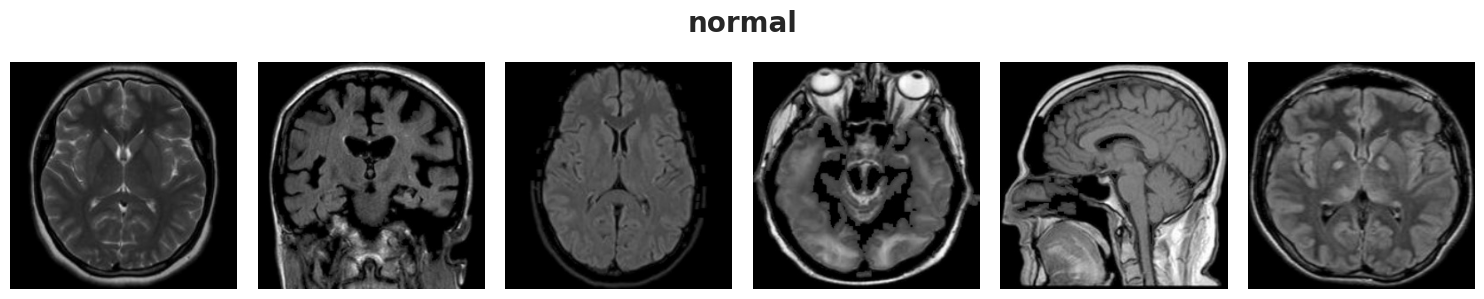

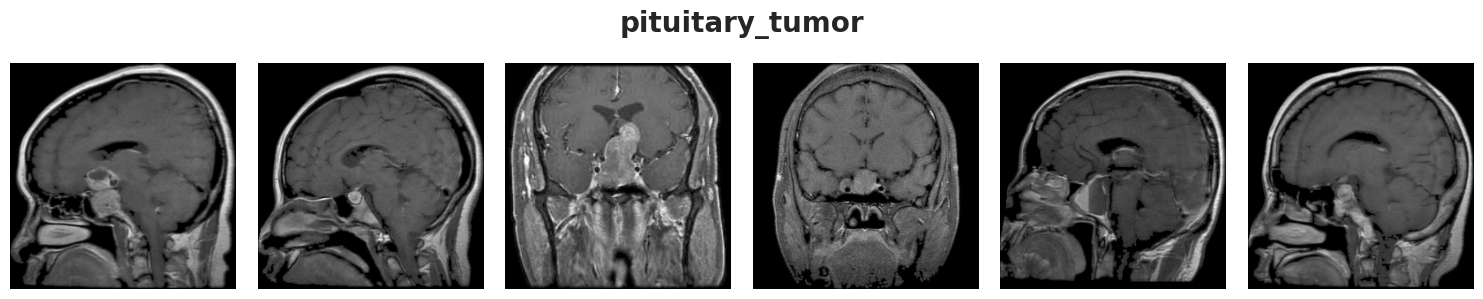

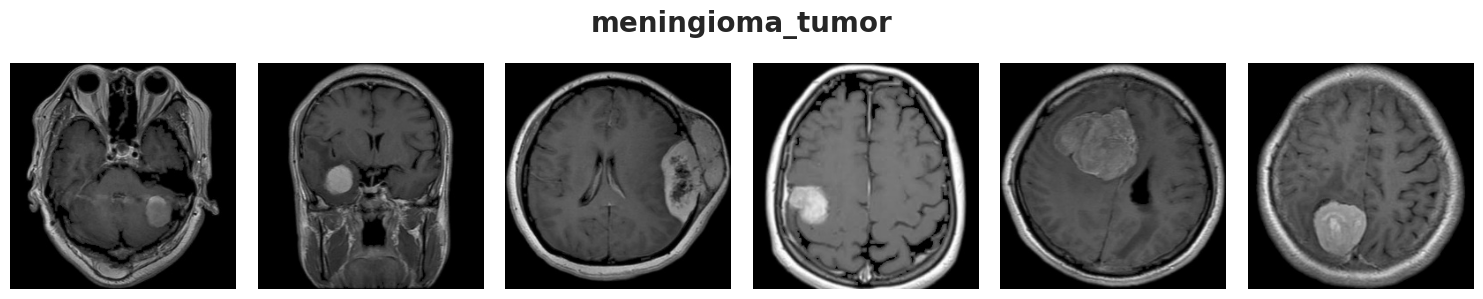

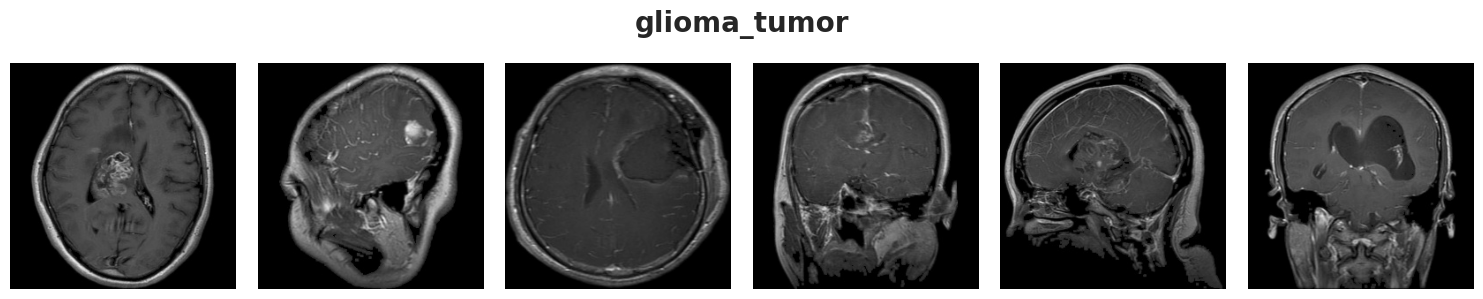

In [6]:
# A loop to iterate below codes for each class
for class_name in classes :
    # To create a plot with 1 row and 6 column
    fig, ax = plt.subplots(1, 6, figsize=(15, 3))
    # Define a variable for each class_name's path by joining base_directory and each class_name
    class_path = os.path.join(base_dir, class_name)
    # Files is a list of all image names in each folder (class)
    files = os.listdir(class_path)
    # Choose 6 random image from each class to show in plot
    random_images = random.choices(files, k=6)
    # A loop to iterate in each 6 random images
    for i in range(6) :
        # print class_name as suptitle for each class
        plt.suptitle(class_name, fontsize=20, fontweight='bold')
        # variable img is path of image, by joining class_path and image file name
        img = os.path.join(class_path ,random_images[i])
       # load image in img variable using keras.utils.load_img(image_path) 
        img = keras.utils.load_img(img)
        # Plot image
        ax[i].imshow(img)
        # Turn axis off
        ax[i].axis('off')
    # Make plots to become nearer to each other
    plt.tight_layout()

<div style="background-color:#f4edea; padding: 20px 10px 10px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ In continue, create a barplot(horizon barplot) that each plot represent number of images in each classes.
    </p>
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ Start with create a empty list to store count of each classes with loop over classes(folders) and count number of files(images) in them. At last plot them with <b>seaborn.barplot</b> .
    </p>
</div>

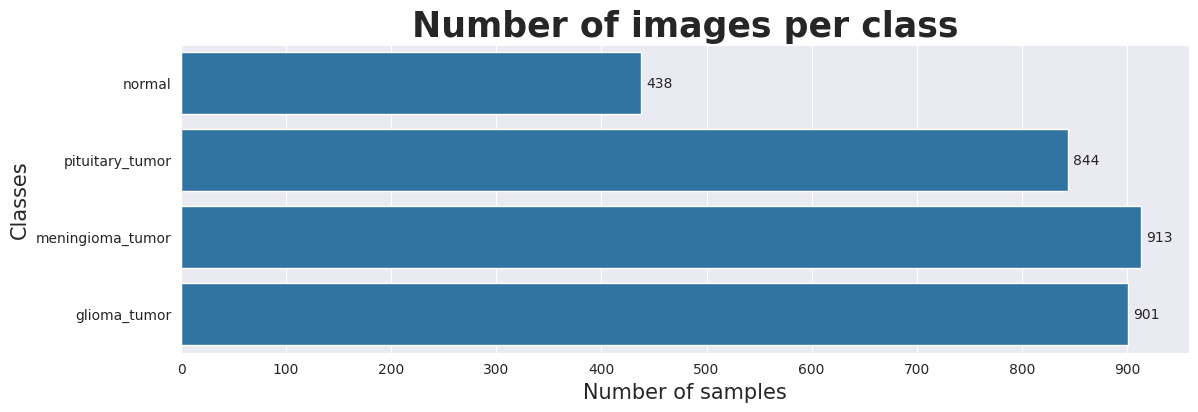

In [7]:
# Count is a list to store number of images for each class.
counts = [] 
# Loop over classes to iterate below code for each class
for class_name in classes :
    # Define class path by joining base_directory and class_name
    class_path = os.path.join(base_dir, class_name)
    # Add number of files in each class to count list
    counts.append(len(os.listdir(class_path)))

# Define plot size
plt.figure(figsize=(13, 4))
# Using seaborn to plot a barplot for each class
ax = sns.barplot(y=classes, x=counts)
# Set X-axis range and ticks
ax.set_xticks(range(0, 950, 100))
# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(width + 5, p.get_y() + p.get_height()/2., 
            '{}'.format(counts[i]),
            va="center", fontsize=10)
# Set plot title
plt.title('Number of images per class', fontsize=25, fontweight='bold')
# Set Y-axis label
plt.ylabel('Classes', fontsize=15)
# Set X-axis label
plt.xlabel('Number of samples', fontsize=15)
# Show plot
plt.show()

<div style="background-color:#f4edea; padding: 25px 10px 10px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ With adding numbers in count list, we have sumation of all samples(number of images) .
    </p>
</div>

In [8]:
# Make sumation of all values in count list as all image counts.
sum_count_before = sum(counts)
print(colored(f'Number of all images is : {sum_count_before}', 'blue', attrs=['bold']))

Number of all images is : 3096


<a id='step3'></a>
# <div style="background-color:#0A2342;background-size: cover;font-family:tahoma;font-size:175%;text-align:center;border-radius:25px 50px; padding:10px; border:solid 2px #09375b"><span style="color:red"><b>Step 3 | <b></span><span style="color:#f2f2f2"><b>Data Preprocessing</b></span></div>

##### [🏠 Tabel of Contents](#tbl_content)

<a id='step31'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 3.1 | <b></span><span style="color:#1d84b5"><b>Create Tesorflow Dataset</b></span></span>

<div style="background-color:#f4edea; padding: 25px 10px 10px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ With calling <b>image_dataset_from_directory(main_directory, labels='inferred')</b> will return a <b>tf.data.Dataset</b> that yields batches of images from the subdirectories 'normal', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor', together with labels 0, 1, 2, 3 to convert data to <b>tensorflow.dataset</b>. 
    </p>
</div>

In [9]:
# Convert our data to tensorflow dataset by keras.utils.image_dataset_from_directory
train_full = keras.utils.image_dataset_from_directory(
    directory=base_dir,        # Path of base directory
    labels='inferred',         # to generate labels from the directory structure
    label_mode='categorical',  # type of labels
    class_names=classes,       # list of class_names
    shuffle=True,              # To shuffle dataset
    seed=42,                   # Optional random seed for shuffling and transformations
    batch_size=32,             # Define batch size
    image_size=(224, 224)      # Size to resize images to after they are read from disk
 )

Found 3096 files belonging to 4 classes.


<div style="background-color:#c5d8d1; padding: 25px 0px 10px 0px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">✅ As we can see, keras detect all of data that belong to 4 classes. 
    </p>
</div>

<div style="background-color:#f4edea; padding: 25px 10px 10px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ Before going to next step, we <b>shuffle</b> dataset to make more accurate result from our data.
    </p>
</div>

In [10]:
# Shuffle dataset again after creation
train_full = train_full.shuffle(1024).prefetch(tf.data.AUTOTUNE)

<a id='step32'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 3.2 | <b></span><span style="color:#1d84b5"><b>Create Train, Validation and Test Dataset</b></span></span>

<div style="background-color:#f4edea; padding: 25px 10px 10px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ In this step, we want to devide dataset to train, validation and test dataset as below :<br> Train--->80% of data<br> Valid--->10% of data<br> Test--->10% of data
    </p>
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ First calculate all batches in main dataset, then with <b>take</b> and <b>skip</b> split it.
    </p>
</div>

In [11]:
# Print Number of all batches in dataset
num_of_full_train_batches = len(list(train_full))
print(colored(f'Number of batches in train_full : {num_of_full_train_batches}', 'black', attrs=['bold']))

Number of batches in train_full : 97


In [50]:
# Define variable to store number of batches for train dataset
num_train_batches = int(num_of_full_train_batches * 0.80)
# Define variable to store number of batches for validation and test dataset
num_valid_test_batches = num_of_full_train_batches - num_train_batches


# Print the TARGET : number of batches for train, validation and test dataset to each
print(colored(' Target : ', 'green', attrs=['bold']))
print('-'*35)
print(colored(f'Number of  Train  batches : {num_train_batches}', 'blue', attrs=['bold']))
print(colored(f'Number of Validation batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))
print(colored(f'Number of Test batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))

 Target : 
-----------------------------------
Number of  Train  batches : 77
Number of Validation batches : 10
Number of Test batches : 10


<div style="background-color:#f4edea; padding: 25px 0px 10px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ <b>Take : </b>Creates a Dataset with at most count elements from this dataset. </p>
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ <b>Skip : </b> Creates a Dataset that skips count elements from this dataset.. </p>
</div>

In [14]:
# Shuffle dataset
train_full = train_full.shuffle(buffer_size=3)

# Apply above settings to main dataset to split to train, validation and test dataset
train_ds = train_full.take(num_train_batches)
remain_ds = train_full.skip(num_train_batches)
valid_ds = remain_ds.take(num_valid_test_batches//2) 
test_ds = remain_ds.skip(num_valid_test_batches//2)

In [15]:
# Print number of batches in train, validation and test dataset after split them
print(colored(f'Number of train batches : {len(list(train_ds))}', 'green', attrs=['bold']))
print(colored(f'Number of valid batches : {len(list(valid_ds))}', 'green', attrs=['bold']))
print(colored(f'Number of test  batches : {len(list(test_ds))}', 'green', attrs=['bold']))

Number of train batches : 77
Number of valid batches : 10
Number of test  batches : 10


<div style="background-color:#c5d8d1; padding: 25px 0px 10px 0px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">✅ As we can see, Dataset completely split to train, validation and test with expected number of batches.
    </p>
</div>

<a id='step4'></a>
# <div style="background-color:#0A2342;background-size: cover;font-family:tahoma;font-size:175%;text-align:center;border-radius:25px 50px; padding:10px; border:solid 2px #09375b"><span style="color:red"><b>Step 4 | <b></span><span style="color:#f2f2f2"><b>Modeling</b></span></div>

##### [🏠 Tabel of Contents](#tbl_content)

<a id='step41'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 4.1 | <b></span><span style="color:#1d84b5"><b>Pre-Trained Model</b></span></span>

<div style="background-color:#f4edea; padding: 25px 10px 10px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ <b>Transfer learning</b> consists of taking features learned on one problem, and leveraging them on a new, similar problem. For instance, features from a model that has learned to identify racoons may be useful to kick-start a model meant to identify tanukis.
Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.
The most common incarnation of transfer learning in the context of deep learning is the following workflow:

1) Take layers from a previously trained model.
2) Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3) Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
4) Train the new layers on your dataset.
    </p>
</div>

<div style="background-color:#f4edea; padding: 25px 10px 10px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ <b>ResNet50V2</b> is a modified version of ResNet50 that performs better than ResNet50 and ResNet101 on the ImageNet dataset. In ResNet50V2, a modification was made in the propagation formulation of the connections between blocks. ResNet50V2 also achieves a good result on the ImageNet dataset.
    </p>
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ ResNet50 is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer). Residual neural networks are a type of artificial neural network (ANN) that forms networks by stacking residual blocks.</p>
</div>

In [16]:
# Use ResNet50V2 from keras.application as pre trained model with imagenet weight
pre_trained_model = keras.applications.ResNet50V2(
    weights='imagenet', classes=4, input_shape=(224, 224, 3), include_top=False
)

In [17]:
# Show information of ResNet50V2 layers
pre_trained_model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

<a id='step42'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 4.2 | <b></span><span style="color:#1d84b5"><b>Freeze Pre-Trained Model Layers</b></span></span>

<div style="background-color:#f4edea; padding: 25px 10px 10px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ ResNet50V2 trained with "imagenet" dataset, so we keep all the trained layer and train last layers (from "conv5_block1_preact_bn" to end) with our definded layers together with our MRI images.
    </p>
</div>

In [18]:
# Print all the layer's name in ResNet50V2
for layer in pre_trained_model.layers :
    print(layer.name)

input_layer
conv1_pad
conv1_conv
pool1_pad
pool1_pool
conv2_block1_preact_bn
conv2_block1_preact_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_pad
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_out
conv2_block2_preact_bn
conv2_block2_preact_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_pad
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_out
conv2_block3_preact_bn
conv2_block3_preact_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_pad
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
max_pooling2d
conv2_block3_3_conv
conv2_block3_out
conv3_block1_preact_bn
conv3_block1_preact_relu
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_pad
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_out
conv3_block2

<div style="background-color:#f4edea; padding: 25px 10px 10px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ <b>process is :</b>
    </p>

1) set all layers trainablibity to true, means all the layers will train in fit process .
2) define a flag=False, (set_trainable). 
3) Create a for loop over layers in ResNet50V2 model. 
4) At first, All layer's trainablity is set to Flase (Dont trainble) .
5) When iterator reach target layer, target and layers after that will be trainable.
</div>

In [19]:
# Freeze all layers, except last layer
# The goal is to train just last layer of pre trained model

pre_trained_model.trainable = True               # Whole model is trainable
set_trainable = False                            # Set a flag to False

for layer in pre_trained_model.layers :          # A loop over model's layers
    if layer.name == 'conv5_block1_preact_bn' :  # Define target layer's name (with if condition)
        set_trainable = True                     # Change flag value to True
    if set_trainable :                           # A condition for True flag
        layer.trainable = True                   # Set layer trainablity to True
    else :                                       # else condition
        layer.trainable = False                  # For layers befor our target layer

<a id='step43'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 4.3 | <b></span><span style="color:#1d84b5"><b>Define Layers For Join Pre-Trained Model</b></span></span>

GlobalAveragePooling2D applies average pooling on the spatial dimensions until each spatial dimension is one, and leaves other dimensions unchanged. In this case values are not kept as they are averaged. For example a tensor (samples, 10, 20, 1) would be output as (samples, 1, 1, 1), assuming the 2nd and 3rd dimensions were spatial (channels last).

<div style="background-color:#f4edea; padding: 25px 10px 10px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ I create a some new layers and join this layers on top of the pre-trained model to train them with trainable layers.</p>
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ The <b>GlobalAveragePooling2D</b> applies average pooling on the spatial dimensions until each spatial dimension is one, and leaves other dimensions unchanged .</p>
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ The <b>Dropout</b> layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.</p>
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ The <b>Flattens</b>, Flattens the input. Does not affect the batch size.</p>
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ The <b>Dense layer </b>Just your regular densely-connected NN layer.</p>
</div>

In [20]:
# Add custom layers on top of the base model
model = keras.models.Sequential()
model.add(pre_trained_model)                           # At first add our pre-trained model
model.add(keras.layers.Dropout(0.5))                   # Use a Dropout layer to avoid over-fitting
model.add(keras.layers.GlobalAveragePooling2D())       # Apply GlobalAveragePooling2D
# model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation='relu')) # Add a Dense layer with 1024 neuron with activation='relu'
model.add(keras.layers.Dropout(0.5))                   # Use a Dropout layer to avoid over-fitting
model.add(keras.layers.Dense(512, activation='relu'))  # Add a Dense layer with 512 neuron with activation='relu'
model.add(keras.layers.Dropout(0.5))                   # Use a Dropout layer to avoid over-fitting
model.add(keras.layers.Dense(4, activation='softmax')) # Add a Dense layer with number fo classes neuron as output with activation='softmax'

<div style="background-color:#f4edea; padding: 25px 10px 10px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ To show model diagram, we can use <b>keras.utils.plot_model</b> to represent sequence of layers we created. </p>
</div>

In [21]:
# Afunction to build model
model.build()

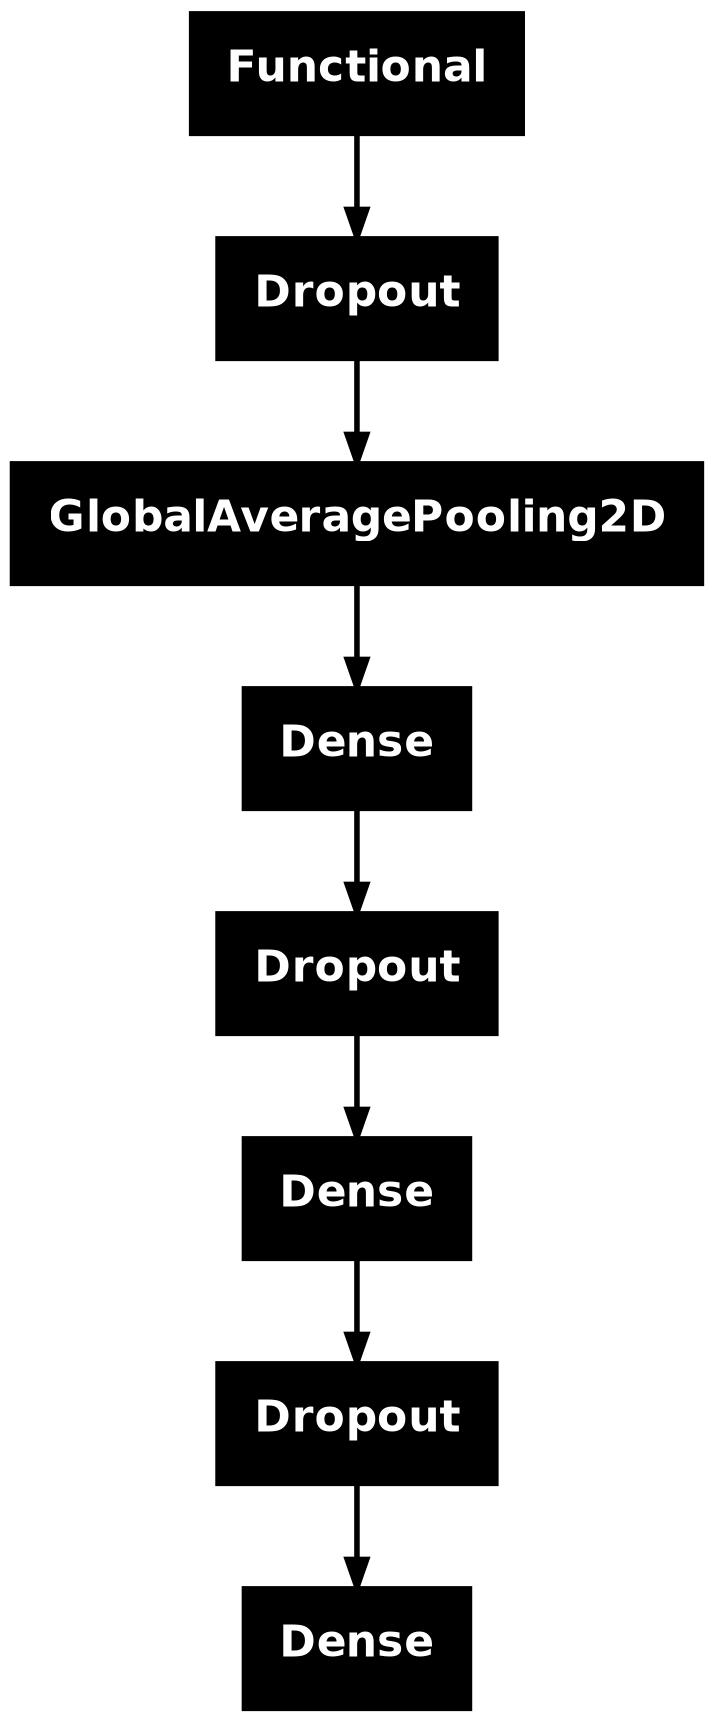

In [56]:
# Plot our defines model by keras.utils.plot_model
keras.utils.plot_model(
    model,                        # A Keras model instance
    to_file="model.png",          # "name.format" to save with
    show_shapes=False,            # Whether to display shape information
    show_dtype=False,             # Whether to display layer dtypes
    show_layer_names=False,       # Whether to display layer names
    rankdir="TB",                 # An argument passed to PyDot librariy
    expand_nested=False,          # whether to expand nested Functional models into clusters
    dpi=200,                      # Image resolution in dots per inch
    show_layer_activations=False, # Display layer activations
    show_trainable=False,         # whether to display if a layer is trainable.
)

<a id='step44'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 4.4 | <b></span><span style="color:#1d84b5"><b>Compile Model</b></span></span>

In [ ]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

<a id='step45'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 4.5 | <b></span><span style="color:#1d84b5"><b>Call-Backs</b></span></span>

<div style="background-color:#f4edea; padding: 25px 10px 10px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ A <b>callback</b> is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).</p>

<p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">You can use callbacks to:

1) Write TensorBoard logs after every batch of training to monitor your metrics
2) Periodically save your model to disk
3) Do early stopping
4) Get a view on internal states and statistics of a model during training
5) ...and more
    </p>
</div>

In [24]:
# Model CheckPoint Call-Back, to save best model parameters as a .keras file
checkpoint_cb = keras.callbacks.ModelCheckpoint('MyModel.keras', save_best_only=True) 

# Early Stoping Call-Backc to stop trainig process after 'patience' epochs if the metric doesn't grow
earlystop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

<a id='step46'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 4.6 | <b></span><span style="color:#1d84b5"><b>Train Model</b></span></span>

<div style="background-color:#f4edea; padding: 25px 10px 10px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ Here for train model, we choose epochs=100, by defining appropriate call backs, this will not train for full epochs.
    </p>
</div>

In [25]:
# Train model by .fit function
history = model.fit(
    train_ds,                                          # Dataset to train model
    epochs=100,                                        # Number of epochs to train
    validation_data=valid_ds,                          # Validation dataset
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr] # List of call backs
)

Epoch 1/100
 1/77 ━━━━━━━━━━━━━━━━━━━━ 42:33 34s/step - accuracy: 0.3750 - loss: 1.5588

I0000 00:00:1708786437.243965   19234 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1708786437.270542   19234 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/77 ━━━━━━━━━━━━━━━━━━━━ 15s 586ms/step - accuracy: 0.3795 - loss: 1.3550

W0000 00:00:1708786465.990562   19237 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.4185 - loss: 1.2854

W0000 00:00:1708786473.794536   19234 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 72s 501ms/step - accuracy: 0.4197 - loss: 1.2833 - val_accuracy: 0.1500 - val_loss: 2.0804 - learning_rate: 1.0000e-04
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 18s 225ms/step - accuracy: 0.7290 - loss: 0.7079 - val_accuracy: 0.6938 - val_loss: 0.7297 - learning_rate: 1.0000e-04
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 214ms/step - accuracy: 0.8571 - loss: 0.4257 - val_accuracy: 0.8844 - val_loss: 0.2850 - learning_rate: 1.0000e-04
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 220ms/step - accuracy: 0.9044 - loss: 0.2868 - val_accuracy: 0.9531 - val_loss: 0.1196 - learning_rate: 1.0000e-04
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - accuracy: 0.9311 - loss: 0.2012 - val_accuracy: 0.9312 - val_loss: 0.1636 - learning_rate: 1.0000e-04
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 221ms/step - accuracy: 0.9406 - loss: 0.1771 - val_accuracy: 0.9625 - val_loss: 0.1108 - learning_rate: 1.0000e-04
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - accuracy

W0000 00:00:1708786666.326555   19238 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - accuracy: 0.9788 - loss: 0.0700 - val_accuracy: 0.9840 - val_loss: 0.0330 - learning_rate: 1.0000e-04
Epoch 14/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - accuracy: 0.9851 - loss: 0.0595 - val_accuracy: 0.9906 - val_loss: 0.0232 - learning_rate: 1.0000e-04
Epoch 15/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 221ms/step - accuracy: 0.9856 - loss: 0.0397 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 5.0000e-05
Epoch 16/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 222ms/step - accuracy: 0.9932 - loss: 0.0158 - val_accuracy: 1.0000 - val_loss: 0.0010 - learning_rate: 5.0000e-05
Epoch 17/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - accuracy: 0.9944 - loss: 0.0138 - val_accuracy: 1.0000 - val_loss: 0.0013 - learning_rate: 5.0000e-05
Epoch 18/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - accuracy: 0.9924 - loss: 0.0267 - val_accuracy: 0.9969 - val_loss: 0.0097 - learning_rate: 5.0000e-05
Epoch 19/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - ac

In [26]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
# Show 5 tails of dataframe
result_df.tail()

,accuracy,loss,val_accuracy,val_loss,learning_rate
46,0.999593,0.001198,1.0,0.002776,1.000000e-06
47,0.999593,0.001542,1.0,0.001684,1.000000e-06
48,1.000000,0.001540,1.0,0.000023,1.000000e-06
49,1.000000,0.001158,1.0,0.000932,1.000000e-06
50,0.999188,0.003752,1.0,0.000017,1.000000e-06


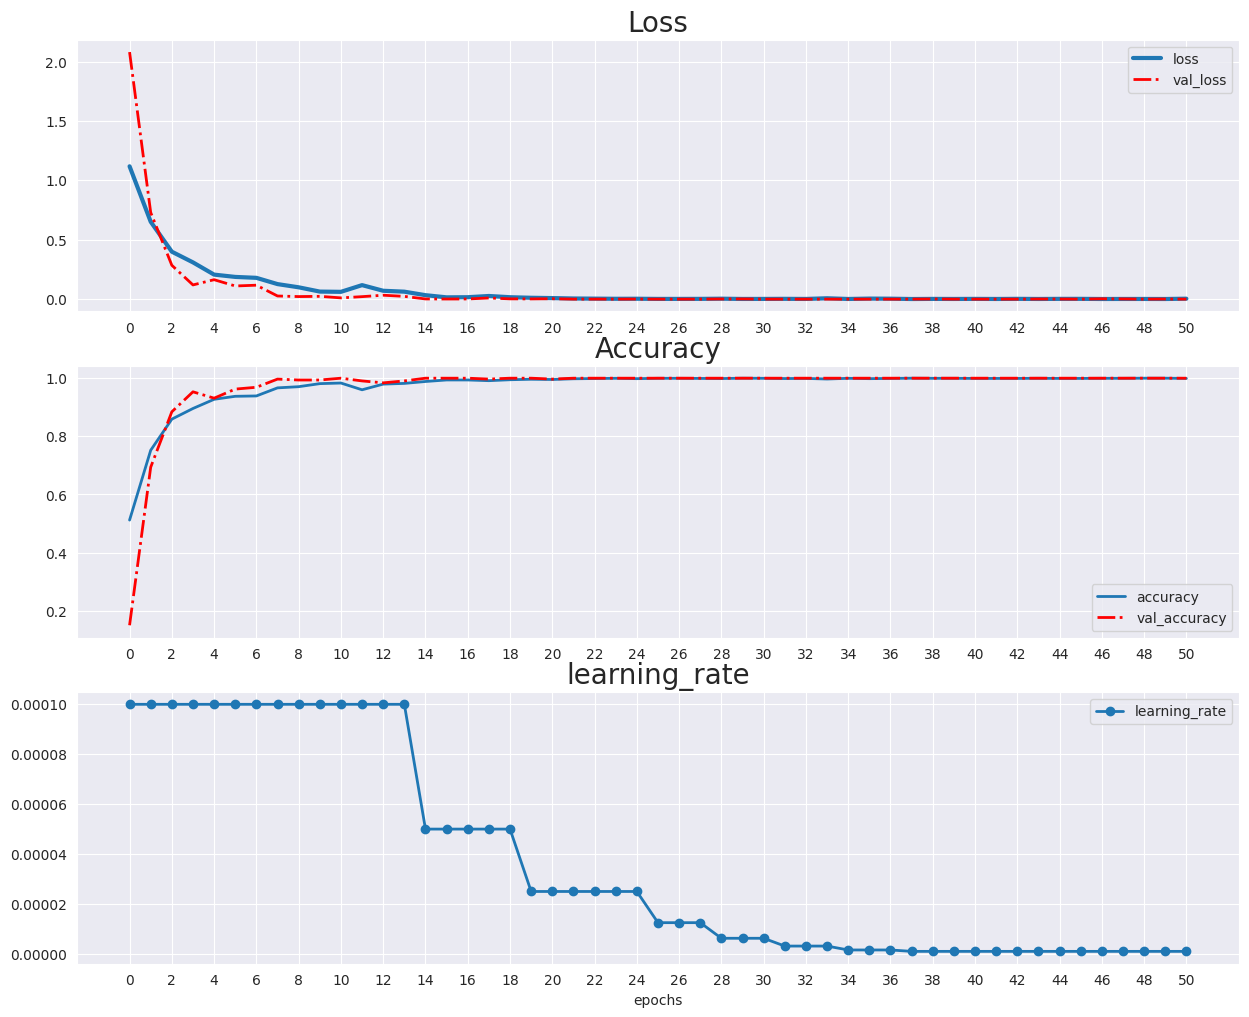

In [41]:
# Define a X variable to store range of epochs
x = np.arange(len(result_df))

# Create a plot with 3 row and 1 col with size of (15, 12)
fig, ax = plt.subplots(3, 1, figsize=(15, 12))

# AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)                          
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].set_xticks(np.arange(0, len(x), 2))
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].set_xticks(np.arange(0, len(x), 2))
ax[1].legend()

#  AX2 : Loss
ax[2].plot(x, result_df.learning_rate, label='learning_rate', linewidth=2, marker='o')
ax[2].set_title('learning_rate', fontsize=20)
ax[2].set_xlabel('epochs')
ax[2].set_xticks(np.arange(0, len(x), 2))
ax[2].legend()

plt.show()

<a id='step47'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 4.7 | <b></span><span style="color:#1d84b5"><b>Evaluation</b></span></span>

In [28]:
# checkpoint callback, save base model weights in "MyModel.keras".
# So, we should load it by keras.models.load_model
best_model = keras.models.load_model('MyModel.keras')

In [61]:
# Evaluate model by model.evaluate()
loss, accuracy = best_model.evaluate(test_ds)
print()
print(colored(f'Loss : {loss}', 'green', attrs=['bold']))
print(colored(f'Accuracy : {accuracy*100}%', 'green', attrs=['bold']))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 1.0000 - loss: 9.5755e-05

Loss : 7.377217843895778e-05
Accuracy : 100.0%


<a id='step5'></a>
# <div style="background-color:#0A2342;background-size: cover;font-family:tahoma;font-size:175%;text-align:center;border-radius:25px 50px; padding:10px; border:solid 2px #09375b"><span style="color:red"><b>Step 5 | <b></span><span style="color:#f2f2f2"><b>Predict</b></span></div>

##### [🏠 Tabel of Contents](#tbl_content)

<div style="background-color:#f4edea; padding: 25px 10px 10px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ I've made these Widgets in which we can upload images from our local machine and predict whether the MRI scan has a Brain Tumour or not and to classify which Tumor it is. Unfortunately, it doesn't work on Kaggle but you can play around with this by downloading the notebook on your machine :)
    </p>
</div>

In [228]:
# A function to load uploaded image, pre-processing and predict model
def predict_image(upload) :
    # Store a location in memory that image stored(with uploader)
    uploaded_content = list(upload.value)[0].content
    # Load image from memory to img variable by io.BytesIO and PIL.Image
    img = Image.open(io.BytesIO(uploaded_content))
    # Load image by cv2
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    # Resize image to (224, 224) whitch is ResNet50V2 input size
    img = cv2.resize(opencvImage,(224,224))
    # Reshape image array to add 3 channels
    img = img.reshape(1,224,224,3)
    # Predict model with best_model
    p = best_model.predict(img)
    # Return high probability of predictions
    p = np.argmax(p,axis=1)[0]
    
    
    if p==0:
        print('The model predicts that there is no tumor')
        
    elif p==1:
        p='Pituitary Tumor'
        
    elif p==2:
        p='Meningioma Tumor'
        
    if p==3:
        p='Glioma Tumor'
    
    if p!=0:
        print()
        print(colored(f'The Model predicts that it is a {p}', 'green'))

<div style="background-color:#f4edea; padding: 25px 10px 10px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ You can upload your MRI image from your Hard-disk by clicking on button below. 
    </p>
</div>

After uploading the image, you can click on the Predict button below to make predictions:

In [229]:
# Create Upload button by ipywidget

upload = FileUpload(accept='.jpg', multiple=False)
display(upload)

FileUpload(value=(), accept='.jpg', description='Upload')

<div style="background-color:#f4edea; padding: 25px 10px 10px 10px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:left">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;">➡️ After uploading the image, you can click on the Predict button below to make predictions:
</div>

In [233]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            predict_image(upload)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

<a id="author"></a>
<div style="border:3px solid navy; border-radius:30px; padding: 15px; background-size: cover; font-size:100%; text-align:left; background-image: url(https://i.postimg.cc/sXwGWcwC/download.jpg); background-size: cover">

<h4 align="left"><span style="font-weight:700; font-size:150%"><font color=#d10202>Author:</font><font color=navy> Nima Pourmoradi</font></span></h4>
<h6 align="left"><font color=#ff6200><a href='https://github.com/NimaPourmoradi'>github: https://github.com/NimaPourmoradi</font></h6>
<h6 align="left"><font color=#ff6200><a href='https://www.kaggle.com/nimapourmoradi'>kaggle : https://www.kaggle.com/nimapourmoradi</a></font></h6>
<h6 align="left"><font color=#ff6200><a href='https://www.linkedin.com/in/nima-pourmoradi-081949288/'>linkedin : www.linkedin.com/in/nima-pourmoradi</a></font></h6>
<h6 align="left"><font color=#ff6200><a href='https://t.me/Nima_Pourmoradi'>Telegram : https://t.me/Nima_Pourmoradi</a></font></h6>

<img src="https://i.postimg.cc/t4b3WtCy/1000-F-291522205-Xkrm-S421-Fj-SGTMR.jpg">

<div style="background-color:#c5d8d1; padding: 25px 0px 10px 0px; border-radius: 10px; box-shadow: 2px 2px 4px 0 rgba(0, 0, 0, 0.1);border:0px solid #0A2342; text-align:center">
    <p style="font-size:18px; font-family:tahoma; line-height: 2em; text-indent: 20px;"><b>✅ If you like my notebook, please upvote it ✅
    </b></p>
</div>

##### [🏠 Tabel of Contents](#tbl_content)